In [2]:
%matplotlib widget
import matplotlib.pyplot as plt
import numpy as np 

%reload_ext autoreload
%aimport Funcs
%aimport fluid_flow
%aimport parameters
from Funcs import advance_adv_diff_RK3
from fluid_flow import advance_fluid_flow,advance_fluid_flow_2, set_boundary, dt_fluid_flow

from parameters import * # <-- dangerous; make sure to put only global constants in that file

In [3]:
N, M = 100,100

dx, dy, Ns_c, Nc_lw = parameters.set_resolution(N,M)
dt = dt_fluid_flow(dx, Fo=0.3)

## stationnarity
We define some metrics which compare two arrays $a$ and $b$. In our case this will be $u$ or $v$ at different times $T_n$ of the simulation.

In [4]:
def metric_L0(a, b):
    norm = np.abs(a).max()
    return np.abs(a-b).max() / norm

def metric_RMS(a, b):
    norm = np.abs(a).max()
    return np.sqrt(np.mean((a-b)**2)) / norm

Next, we define $t_n = n \cdot Nt \,  \Delta t + t_0$ of the simulation, where $n = 1,.., N_{loop}$, $t_0 = N_{t_0} \Delta t$ is the initial time given to the simulation before starting with the actual analysis (we are not interested in the strong fluctuations at the very beginning). Furthermore, one can chose $N_t \gg 1$ since we don't need to compare the results after every single time step.

In [5]:
from math import sin, pi
dt = dt_fluid_flow(dx, Fo=0.3)
# initial setup of velocity field
u0 = np.zeros((N,N))
v0 = np.copy(u0)
u0,v0 = set_boundary(u0,v0,Ns_c, Nc_lw)
u, v = np.copy(u0), np.copy(v0)

# initial convergence paramater for the Poisson solver:
atol0 = 1e-4

# initial w parameter for the Poisson solver:
w0 = 2 / (1 + sin(pi/N))

# initial iterations before staerting the analysis
Nt0 = 500

# number of iterations between 2 convergence measurements
Nt = 300

# number of convergence measurements
N_loop = 50

# placeholders for the respective metrics
L0 = np.zeros((2,N_loop))
L2 = np.zeros_like(L0)

# initial warm-up:
u, v, P,_ = advance_fluid_flow(Nt0, u, v, advance_adv_diff_RK3, dt)

# convergence analysis:
for i in range(N_loop):
    
    w = w0 # modifying this param. doesn't yield satisfactory results
    atol = atol0*1./(20*i + 1.) # here, we gradually reduce the convergence threshold
    
    u_old, v_old = np.copy(u), np.copy(v)
    u, v, P,_ = advance_fluid_flow(Nt, u, v, advance_adv_diff_RK3, dt, w=w, atol=atol, P=P)
    
    # measurements:
    L0[0,i] = metric_L0(u_old, u)
    L0[1,i] = metric_L0(v_old, v) 
    
    L2[0,i] = metric_RMS(u_old, u)
    L2[1,i] = metric_RMS(v_old, v)

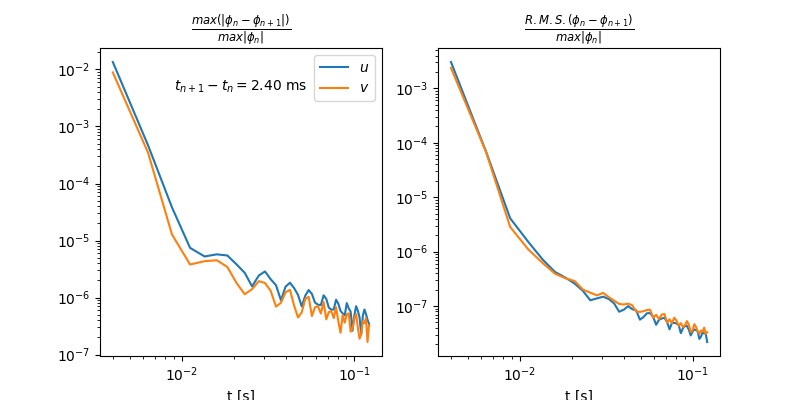

In [6]:
T = np.arange(N_loop) * dt * Nt + dt * Nt0

fig, [ax, ax2] = plt.subplots(1,2, figsize=(8,4), sharex=True)
ax.plot(T, L0[0], label='$u$')
ax.plot(T, L0[1], label='$v$')

ax2.plot(T, L2[0], label='$u$')
ax2.plot(T, L2[1], label='$v$')

ax.set_xlabel('t [s]')
ax2.set_xlabel('t [s]')
ax.set_yscale('log')
ax2.set_yscale('log')
ax.set_xscale('log')
ax2.set_xscale('log')

ax.set_title(r'$\frac{ max ( |\phi_n - \phi_{n+1}| ) } { max |\phi_n| }$')
ax2.set_title(r'$\frac{ R.M.S.( \phi_n - \phi_{n+1} ) }{ max |\phi_n| }$')

s = r'$t_{n+1} - t_n = $' +'${:.2f}$ ms'.format(Nt * dt * 1e3)
ax.text(0.5, 0.9, s, verticalalignment='top', horizontalalignment='center', transform=ax.transAxes)
ax.legend()

Now we see the variation of N and its effects on the simulation status
1. fixing atol this time
2. measuring 3 Time for the same grid size (N) than averaging N_loop=3

In [7]:
print(dt,Nt0,Nt)
T,T0= dt*(Nt),dt*Nt0 # using the same time interval for all the measurements 
print(T,T0)

8.000000000000001e-06 500 300
0.0024000000000000002 0.004000000000000001


In [8]:
import time
N_list = [30,50,70,90,100,120,130,140,180,200,250]
# initial convergence paramater for the Poisson solver:
atol0 = 1e-4
# number of convergence measurements
N_loop = 3

# placeholders for the respective metrics
L0 = np.zeros((2,len(N_list),N_loop))
L2 = np.zeros_like(L0)
time_list = np.zeros((len(N_list),N_loop))
UVP={}
for j in range(len(N_list)):
    N, M = N_list[j],N_list[j]
    print('working on {}'.format(N))
    dx, dy, Ns_c, Nc_lw = parameters.set_resolution(N,M)
    dt = dt_fluid_flow(dx, Fo=0.3)
    
    # initial w parameter for the Poisson solver:
    w0 = 2 / (1 + sin(pi/N))

    # initial iterations before staerting the analysis
    Nt0 = int(T0/dt)

    # number of iterations between 2 convergence measurements
    Nt = int(T/dt)
    
    # initial setup of velocity field
    u0 = np.zeros((N,M))
    v0 = np.copy(u0)
    u0,v0 = set_boundary(u0,v0,Ns_c, Nc_lw)
    u, v = np.copy(u0), np.copy(v0)


    
    # initial warm-up:
    u, v, P,_ = advance_fluid_flow(Nt0, u, v, advance_adv_diff_RK3, dt)

    # convergence analysis:
    
    for i in range(N_loop):
        start= time.time()    
        w = w0 # modifying this param. doesn't yield satisfactory results
        atol = atol0 #atol is fixed
        
        u_old, v_old = np.copy(u), np.copy(v)
        u, v, P,_ = advance_fluid_flow(Nt, u, v, advance_adv_diff_RK3, dt, w=w, atol=atol, P=P)
        if i==0 :UVP[N] = np.array([u.copy(),v.copy(),P.copy()])
        # measurements:
        L0[0,j,i] = metric_L0(u_old, u)
        L0[1,j,i] = metric_L0(v_old, v) 
        
        L2[0,j,i] = metric_RMS(u_old, u)
        L2[1,j,i] = metric_RMS(v_old, v)
        time_list[j,i]= time.time() - start

working on 30
working on 50
working on 70
working on 90
working on 100
working on 120
working on 130
working on 140
working on 180
working on 200
working on 250


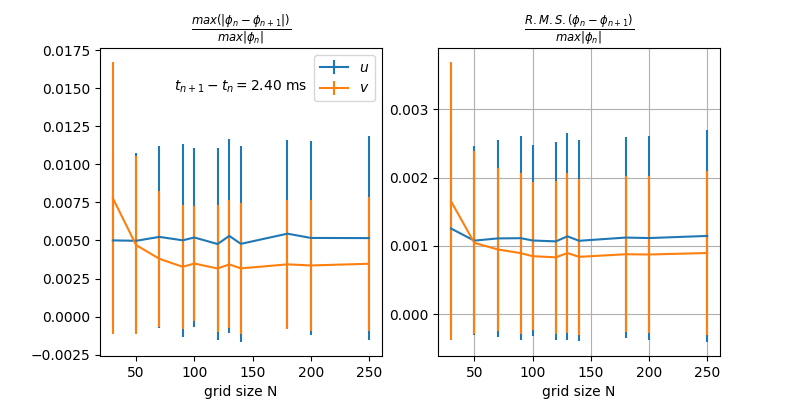

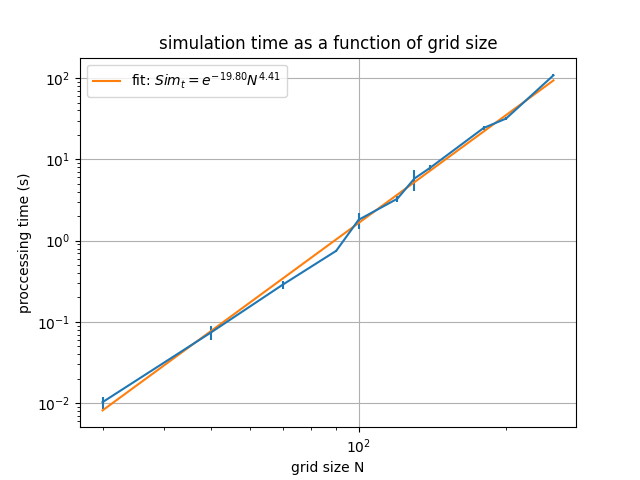

In [13]:
params = np.polyfit(np.log(N_list),np.log(np.mean(time_list[:,:],axis = 1)),deg=1)

fig, [ax, ax2] = plt.subplots(1,2, figsize=(8,4), sharex=True)
ax.errorbar(N_list, (np.mean(L0[0,:,:],axis = 1)),yerr=(np.std(L0[0,:,:],axis = 1)), label='$u$')
ax.errorbar(N_list, (np.mean(L0[1,:,:],axis = 1)),yerr=(np.std(L0[1,:,:],axis = 1)), label='$v$')

ax2.errorbar(N_list, (np.mean(L2[0,:,:],axis = 1)),yerr=(np.std(L2[0,:,:],axis = 1)), label='$u$')
ax2.errorbar(N_list, (np.mean(L2[1,:,:],axis = 1)),yerr=(np.std(L2[1,:,:],axis = 1)), label='$v$')

ax.set_xlabel('grid size N')
ax2.set_xlabel('grid size N')
ax.set_yscale ('linear')
ax2.set_yscale('linear')
ax.set_xscale ('linear')
ax2.set_xscale('linear')

ax.set_title(r'$\frac{ max ( |\phi_n - \phi_{n+1}| ) } { max |\phi_n| }$')
ax2.set_title(r'$\frac{ R.M.S.( \phi_n - \phi_{n+1} ) }{ max |\phi_n| }$')

s = r'$t_{n+1} - t_n = $' +'${:.2f}$ ms'.format(Nt * dt * 1e3)
ax.text(0.5, 0.9, s, verticalalignment='top', horizontalalignment='center', transform=ax.transAxes)
ax.legend()
plt.grid()

fig, ax = plt.subplots()
plt.errorbar(N_list,
            np.mean(time_list[:,:],axis = 1),
            yerr=np.std(time_list[:,:],axis = 1) )
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_title('simulation time as a function of grid size')
ax.set_xlabel('grid size N')
ax.set_ylabel('proccessing time (s)')
ax.plot(N_list,np.exp(params[1])*np.array(N_list)**params[0],label = r'fit: $Sim_t = e^{{ {1:5.2f} }}N^{{ {0:4.2f} }}$'.format(round(params[0],ndigits=2),round(params[1],ndigits=2)))
plt.legend()
plt.grid()



**Maximum strain rate**

what is max($|\frac{\partial v}{\partial y}|$) ?


In [14]:
from Funcs import df1_2
a = np.abs(df1_2(v, dy, axis=1))
print(np.max(a[0,:]))

1490.0169184906808


In [15]:
np.max(np.abs(u)),np.max(np.abs(v)) 

(1.189567885948802, 1.0015461960541268)

We can save the velocity field for later use:

In [18]:
from pathlib import Path
print(UVP.keys())
for i in  range(len(N_list)):
    N = N_list[i]
    datap = Path('data/vel_field') / 'UVP_N{}M{}.npy'.format(N,N)
    np.save(datap, UVP[N])

dict_keys([30, 50, 70, 90, 100, 120, 130, 140, 180, 200, 250])


## Visualization

In [19]:

from visualization import plot_velocity_image, plot_velocity_vector_field

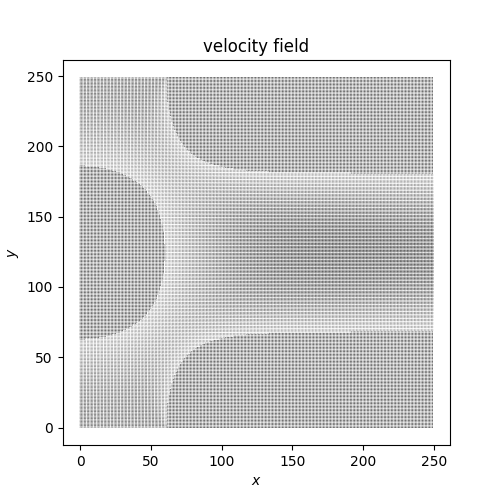

In [20]:

plot_velocity_vector_field(u,v)

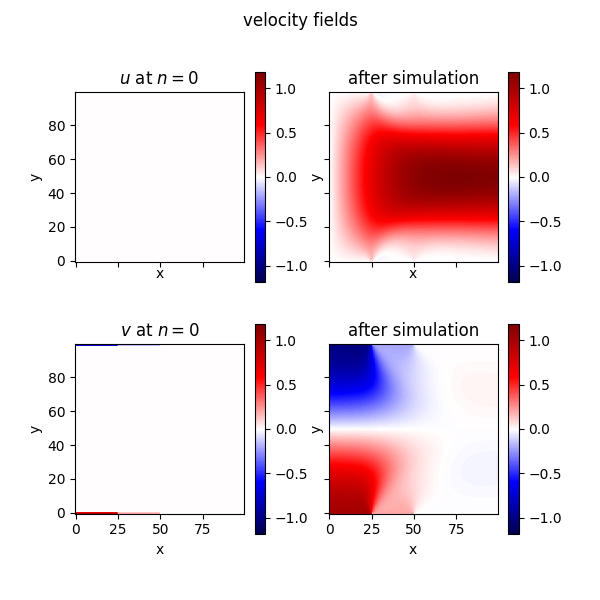

In [13]:
from visualization import plot_velocity_image
plot_velocity_image(u,v,u0,v0)

Now with the help of a modified advance_fluid_flow function we save data for multiple N values in the first 7ms of the flow I have prooven previously that the system is stationnary at around 6.3ms and save data for different N values and save them 